# Predicting Animal Adoptions at the AAC (Austin Animal Center)
***

# Table of Contents
***

## [Goals](#goals)

## [Acquire](#acquire)

## [Prepare](#prepare)

## [Explore](#explore)

## [Model](#model)

## [Conclusion](#conclusion)
<br>

# Goals <a id='goals'></a>
***

My goals for this project is to create a model that will acurrately predict if an animal will be adopted based on information about it

I will deliver the following 
- aac_project_notebook.ipynb
    - This notebook which provides a start-to-finish walkthrough of the project
- README.md
    - A markdown file that provides various information about this project including a data dictionary, project plan, and a link to the source data
- wrangle.py
    - A file that contains all of the custom functions featured in this notebook
- A presentation of the project
    - A 3-5 minute presentation that summarizes the findings of this project (link to presentation slides below)
        - <link>

In [1]:
# establishing environment
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wrangle import get_aac, prep_aac, wrangle_aac

# Acquire<a id='acquire'></a>
I'll begin by acquiring the data from a local CSV file.
***

In [173]:
# reading data in as DF
df = get_aac()

# previewing data
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


### Acquire Takeaways
- Acquired data from local csv file using pandas __read_csv__ function
- Data can also be acquired via the __wrangle_aac__ function in the __wrangle.py__ file
    - Note that the __wrangle_aac__ function will also prep the data for exploration

# Prepare<a id='prepare'></a>
I'm now going to prepare the data for exploration.
***

In [3]:
# previewing data for null value counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [4]:
# previewing age_upon_outcome values
df.age_upon_outcome.value_counts().head(10)

1 year      14355
2 years     11194
2 months     9213
3 years      5157
3 months     3442
1 month      3344
4 years      2990
5 years      2691
4 months     2425
5 months     1951
Name: age_upon_outcome, dtype: int64

In [5]:
# previewing animal_type values
df.animal_type.value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [6]:
# previewing outcome_type values
df.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [7]:
# previewing sex_upon_outcome values
df.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

### Prepping Data via prep_aac function

In [8]:
# prepping data with changes outlined in prepare takeaway section
train, validate, test = prep_aac(df)

In [9]:
# previewing train df
train.head()

,animal_type,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,age_in_weeks_s,is_adopted
11259,cat,1,0,0,Male,1,0,0,1,312,0.240000,0
6981,cat,1,0,0,Male,1,0,0,0,104,0.080000,0
17670,dog,0,1,0,Male,1,0,0,1,28,0.021538,1
65805,cat,1,0,0,Male,1,0,0,1,12,0.009231,1
36724,dog,0,1,0,Male,1,0,0,1,20,0.015385,1


### Prepare Takeaways
After reviewing the data for this project, I elected to make the following changes by creating a function, __prep_aac__, located in the __wrangle.py file__. 

Alternatively, the __wrangle_aac__ function from the __wrangle.py file__ can be ran to both acquire and prep the data simultaneously.

- Drop the following columns
    - animal_id
        - Unique id's won't be useful in predicting outcomes
    - breed
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - color
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - date_of_birth
        - Since I have the age of each animal at the time of outcome, I won't need to calculate their age using this variable
    - datetime, monthyear
        - Duplicate columns that presumably reflect when an outcome (adopted, transferred, etc.) occured
        - The scope of this project will only include data pertaining to outcomes, at a later time I will expand this scope to include data from when each animal was inducted and at that time I will make use of one of these columns
    - outcome_subtype
        - Gives details about outcome (example: why was an animal euthanised?)
        - May prove useful but appears to only be known when the outcome is known (example: (outcome_subtype partner) (outcome_type: transfer) could only be known when an animal is set for transfer to a partner)
        - The value of this project is to create a model that will predict if an animal will be adopted, so outcome_subtype probably wouldn't be set until outcome is set, so I'm going to drop it for now
- Rename columns where appropriate to better reflect the data they represent
- Convert age_upon_outcome to value representing weeks
    - Create scaled version of this column if this becomes a model feature
- Add boolean columns for animal type
    - is_cat
    - is_dog
    - Bird and Livestock will be converted to "is_other" since they make up a very small % of the overall amount
- Transform outcome_type to binary categorical column 'is_adopted' 
- Split sex_upon_outcome into categorical columns for neutered/spaded and sex
    - is_neutered_or_spaded
    - is_male
    - is_female
    - sex_unknown
- Drop null values
    - Very few nulls so dropping won't have a meaningful impact
- Splitting data into train, validate, and test sets

# Explore<a id='explore'></a>
I'm now going to explore the data using plots and hypothesis tests to identify drivers of adoption.
***

### Features: age_in_weeks, animal_type 
Plotting to see a get a general view of the two variables I initally thought would be the most impactful, age and animal type.

Text(0.5, 1.0, 'Young Cats and Dogs are Adopted More Often')

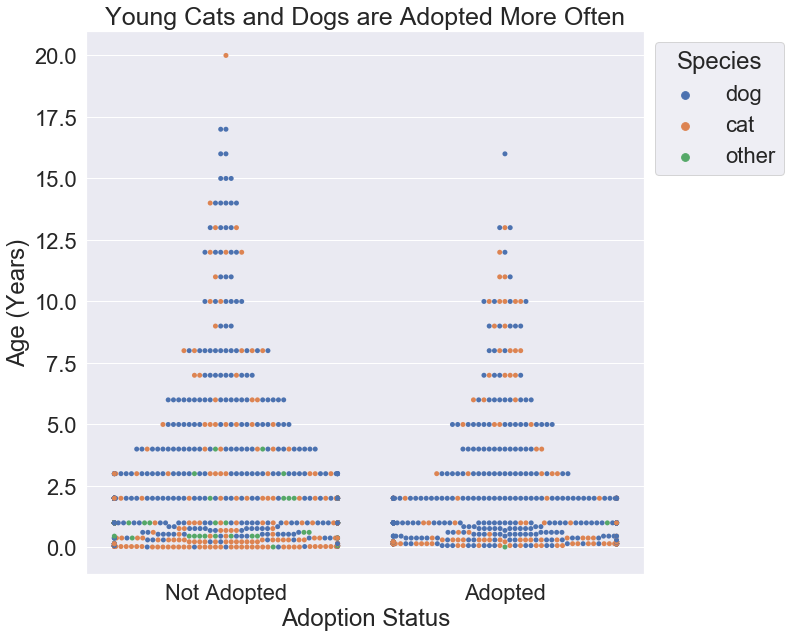

In [182]:
# Our current train DF has over 40,000 rows. To avoid lengthy load times while working with the swarmplot
# I'm going to plot a sample of the train set instead
swarm = train.sample(frac=0.03, replace = False, random_state=123)

# converting age to years
swarm.age_in_weeks = swarm.age_in_weeks / 52

# removing unneeded columns in swarm DF
swarm = swarm[['age_in_weeks', 'is_adopted', 'animal_type']]

# renaming columns so the plots labels are easier to read
swarm.columns = ['Age (Years)', 'Adoption Status', 'Species']

# changing boolean values to be more fitting as x axis labels
swarm['Adoption Status'] = np.where((swarm['Adoption Status'] == 1), 'Adopted', 'Not Adopted')

# creating swam plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set(xticks = [0,1])
ax = sns.swarmplot(x="Adoption Status", y="Age (Years)", data=swarm, hue = 'Species')
plt.legend(bbox_to_anchor=(1.27, 1), title ='Species')
plt.title('Young Cats and Dogs are Adopted More Often', fontsize=25)

- As a city shelter, the AAC seems to take in more cats and dogs than other species
    - This would explain why there are so few "other" animal types in general
    - The "other" animal types may have lower rates of adoption none the less so further exploration is needed
- Seems that younger animals are preferred for adoption over older animals but further exploration is needed

Text(0.5, 1.0, 'Sterilized Animals are Adopted More Often')

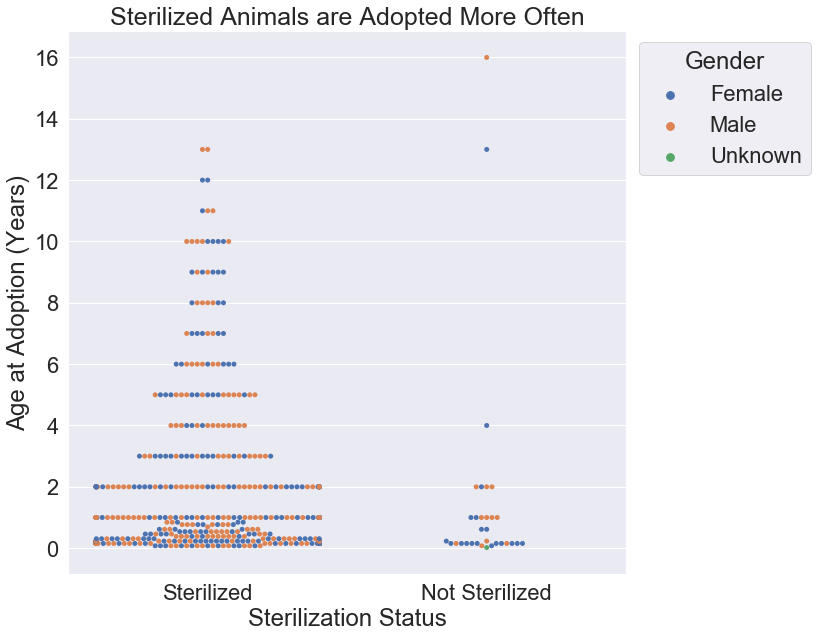

In [292]:
# Our current train DF has over 40,000 rows. To avoid lengthy load times while working with the swarmplot
# I'm going to plot a sample of the train set instead
swarm = train.sample(frac=0.03, replace = False, random_state=123)

swarm = swarm[swarm.is_adopted == 1]

# converting age to years
swarm.age_in_weeks = swarm.age_in_weeks / 52

# removing unneeded columns in swarm DF
swarm = swarm[['age_in_weeks', 'is_neutered_or_spayed', 'sex']]

# renaming columns so the plots labels are easier to read
swarm.columns = ['Age at Adoption (Years)', 'Sterilization Status', 'Gender']

# changing boolean values to be more fitting as x axis labels
swarm['Sterilization Status'] = np.where((swarm['Sterilization Status'] == 1), 'Sterilized', 'Not Sterilized')

# creating swam plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set(xticks = [0,1])
ax = sns.swarmplot(x="Sterilization Status", y="Age at Adoption (Years)", data=swarm, hue = 'Gender')
plt.legend(bbox_to_anchor=(1.35, 1), title ='Gender')
plt.title('Sterilized Animals are Adopted More Often', fontsize=25)

## Feature: animal_type

### Crosstab

In [183]:
# creating crosstab using animal_type and is_adopted columns
observed_atype = pd.crosstab(train.animal_type, train.is_adopted)

observed_atype 

is_adopted,0,1
animal_type,,
cat,9331,7114
dog,13467,11381
other,2354,165


- Crosstab reflects that the % of dog and cat adoptions is much higher than other animal types
- Cat adoption rate is 43%
- Dog adoption rate is 45%
- "Other" adoption rate is 6%
    - Other animals are livestock and other types of animals that are not normally suited for domestic environments hence the lower adoption rates

### Visualization

In [11]:
# setting figure and text size for all plots
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

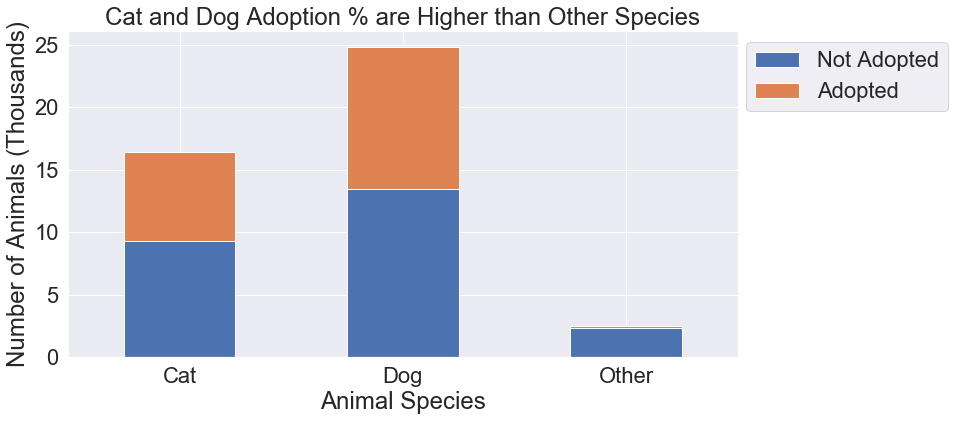

In [12]:
# renaming crosstab columns and index for use in plot
observed_atype.columns = ['Not Adopted', 'Adopted']
observed_atype.index = ['Cat', 'Dog', 'Other']

# creating barplot
atype_plot = observed_atype / 1000
atype_plot.plot.bar(stacked=True, rot=0)
plt.ylabel('Number of Animals (Thousands)')
plt.xlabel('Animal Species')
plt.title('Cat and Dog Adoption % are Higher than Other Species')
plt.legend(bbox_to_anchor=(1.33,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of animal type
<br>
Ha: Adoption is not independent of animal type

In [13]:
# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_atype)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of animal type

## Feature: sex

### Crosstab

In [14]:
# creating crosstab using sex and is_adopted columns
observed_sex = pd.crosstab(train.sex, train.is_adopted)

observed_sex

is_adopted,0,1
sex,,
Female,9889,9329
Male,11670,9301
Unknown,3593,30


- Male adoption rate 44% 
- Female adoption rate 48% 
- Male and female animals are much more likely to be adopted than animals of unknown sex
- Females seem to have a moderate edge over males in their likelihood of being adopted

In [220]:
(train[train.animal_type=='other']).shape

(2519, 17)

In [230]:
train[(train.sex == 'Unknown')& (train.animal_type=='other')].shape

(2094, 17)

- Animals of "other" species make up vast majority of those of unconfirmed sex
    - Center personnel probably aren't trained to identify the sex of uncommon animals

### Visualization

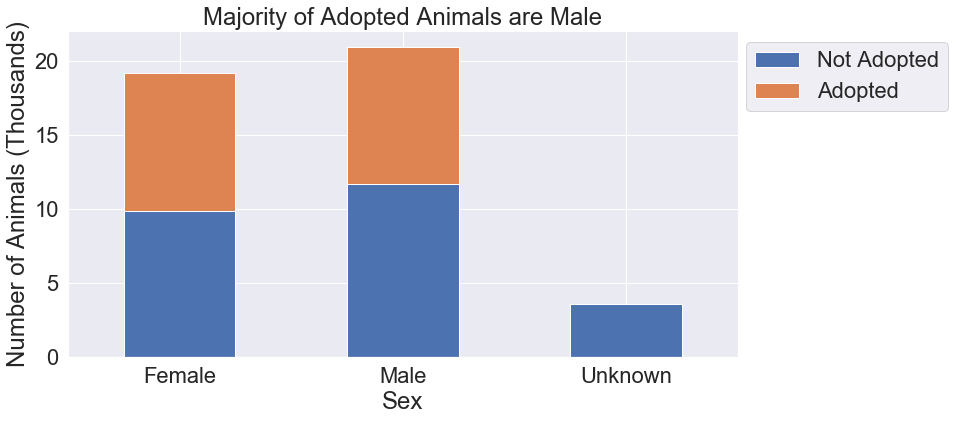

In [15]:
# renaming crosstab columns for plot
observed_sex.columns = ['Not Adopted', 'Adopted']

# creating barplot 
sex_plot = observed_sex / 1000
sex_plot.plot.bar(stacked=True, rot=0)
plt.ylabel('Number of Animals (Thousands)')
plt.xlabel('Sex')
plt.title('Majority of Adopted Animals are Male')
plt.legend(bbox_to_anchor=(1.33,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of sex
<br>
Ha: Adoption is not independent of sex

In [16]:
# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_sex)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of sex

## Feature: neutered_or_spayed

### Crosstab

In [17]:
# creating crosstab using is_neutered_or_spayed column and is_adopted column
observed_nors = pd.crosstab(train.is_neutered_or_spayed, train.is_adopted)

observed_nors

is_adopted,0,1
is_neutered_or_spayed,,
0,13276,842
1,11876,17818


- Crosstab shows that neutered and spayed animals are adopted more often than their intact counterparts

### Visualization

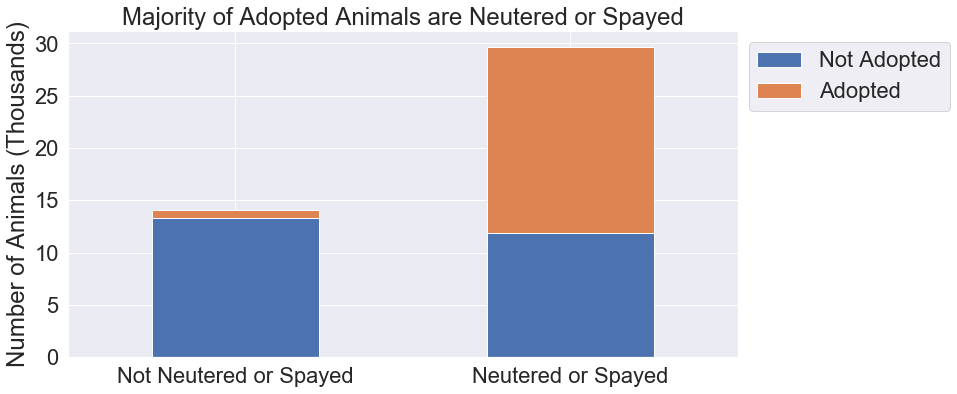

In [18]:
# renaming crosstab index and columns for plot
observed_nors.index = ['Not Neutered or Spayed', 'Neutered or Spayed']
observed_nors.columns = ['Not Adopted', 'Adopted']

# creating barplot
nors_plot = observed_nors / 1000
nors_plot.plot.bar(stacked=True, rot=0)
plt.ylabel('Number of Animals (Thousands)')
plt.title('Majority of Adopted Animals are Neutered or Spayed')
plt.legend(bbox_to_anchor=(1,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of whether an animal is neutered of spayed
<br>
Ha: Adoption is not independent of whether an animal is neutered of spayed

In [19]:
# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_nors)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of whether an animal is neutered or spayed

## Feature: age_in_weeks

In [250]:
train.age_in_weeks.mean()

print('Average age of animals in years:', round(train.age_in_weeks.mean() / 52,1))

Average age of animals in years: 2.1


In [249]:
older = train[train.age_in_weeks > train.age_in_weeks.mean()]

older.groupby('is_adopted').count()

,animal_type,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,age_in_weeks_s,baseline_pred,m1_prediction,m2_prediction,m3_prediction,m4_prediction
is_adopted,,,,,,,,,,,,,,,,
0,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493,7493
1,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603,3603


- Animals who are older than the average age at the center (over 2.1 years old) are adopted in 32% of cases

In [261]:
younger = train[train.age_in_weeks < train.age_in_weeks.mean()]

younger.groupby('is_adopted').count()

,animal_type,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,age_in_weeks_s,baseline_pred,m1_prediction,m2_prediction,m3_prediction,m4_prediction
is_adopted,,,,,,,,,,,,,,,,
0,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659,17659
1,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057,15057


- Animals who are younfer than the average age at the center (under 2.1 years old) are adopted in 46% of cases

In [263]:
oldanimals = train[train.age_in_weeks >= 520]

oldanimals.groupby('is_adopted').count()

,animal_type,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,age_in_weeks_s,baseline_pred,m1_prediction,m2_prediction,m3_prediction,m4_prediction
is_adopted,,,,,,,,,,,,,,,,
0,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413
1,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434


- Animals who are 10 years or older have an adoption rate of ~23%

### Visualization

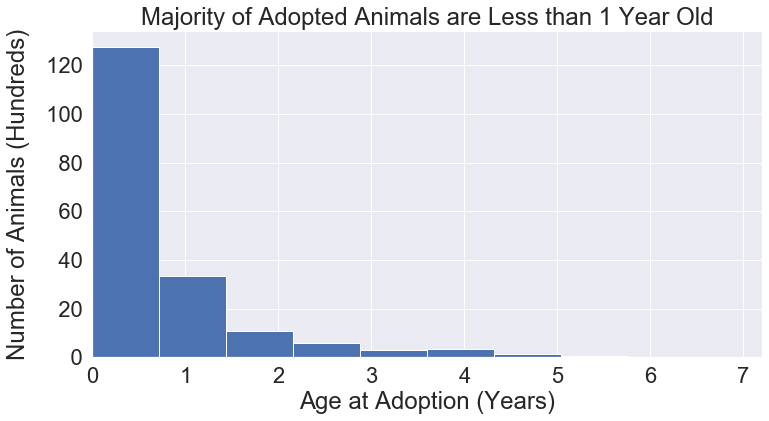

In [20]:
# creating series of data from adopted animals
adopted = train[train.is_adopted == 1].age_in_weeks

# creating histogram of adopted animal ages
fig, ax1 = plt.subplots()
ax1.hist(adopted / 52)
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:5.0f}'.format(x / 100) for x in y_vals])
ax1.set_xticklabels(np.arange(0, 18, step=1))
plt.xlabel('Age at Adoption (Years)')
plt.ylabel('Number of Animals (Hundreds)')
plt.title('Majority of Adopted Animals are Less than 1 Year Old')
ax1.margins(x=0)
plt.show()

### Two-Sample, One-Tailed T-Test

### Hypothesis
<br>
H0: The average age of animals who are adopted is equal to or greater than the average age of animals who are not adopted
<br>
Ha: The average age of animals who are adopted is less than the average age of animals who are not adopted

In [21]:
# x1 = series of ages of animals who were adopted
# x2 = series of ages of animals who were not adopted
x1 = train[train.is_adopted == 1].age_in_weeks
x2 = train[train.is_adopted == 0].age_in_weeks

# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p/2}')
print (f't = ',t)

alpha = .05

p = 1.7634740875777462e-182
t =  -28.919521980419926


- Since p is less than alpha and t is negative, I'm rejecting the null hypothesis that the average age of animals who are adopted is equal to or greater than the average age of animals who are not adopted

### Exploration Takeaways
- Crosstabs showed stark differences in the adoption rates of animals with animal type "unknown", unidentified sex, and those who had not been spayed or neutered from their alternate counterparts
    - These differences were also reflected in bar plots produced by their data
- Chi-squared tests showed that animal type, sex, and whether an animal is spayed or neutred are not independent of whether an animal is adopted 
- A two-sample, one-tailed t-test gave evidence that the average age of adopted animals is lower than the average age of unadopted animals

# Model<a id='model'></a>
I'll now create several models that will predict whether an animal was adopted based on it's various features.
***

## Baseline

In [22]:
# checking most common value of target variable
# ie. are animals more adopted more often than not?
train.is_adopted.value_counts()

0    25152
1    18660
Name: is_adopted, dtype: int64

In [23]:
# setting baseline prediction to 0
train['baseline_pred'] = 0

In [24]:
# printing performance metrics
print(classification_report(train.is_adopted, train.baseline_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     25152
           1       0.00      0.00      0.00     18660

    accuracy                           0.57     43812
   macro avg       0.29      0.50      0.36     43812
weighted avg       0.33      0.57      0.42     43812



## Train

In [25]:
# setting target variable
y_train = train['is_adopted']

### Model 1 - Logistic Regression

In [26]:
# setting feature for model
X_train_m1 = train[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                    'sex_unknown', 'is_neutered_or_spayed']]

# creating logistic regression object
lr = LogisticRegression(random_state=123)

# fitting model to data
lr.fit(X_train_m1, y_train)

# creating column with model predictions
train['m1_prediction'] = lr.predict(X_train_m1)

# printing performance metrics
print(classification_report(train.is_adopted, train.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     25152
           1       0.66      0.84      0.74     18660

    accuracy                           0.75     43812
   macro avg       0.76      0.76      0.75     43812
weighted avg       0.77      0.75      0.75     43812



### Model 2 - Random Forest

In [27]:
# creating DF with selected features for logistic regression model
X_train_m2 = train[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                    'sex_unknown', 'is_neutered_or_spayed']]

# creating random forest object
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf = 3,
                            n_estimators=100, max_depth=4, random_state=123)

# fitting to data
rf.fit(X_train_m2, y_train)

# making predictions
train['m2_prediction'] = rf.predict(X_train_m2)

# printing performance metrics
print(classification_report(train.is_adopted, train.m2_prediction))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     25152
           1       0.71      0.75      0.73     18660

    accuracy                           0.76     43812
   macro avg       0.76      0.76      0.76     43812
weighted avg       0.76      0.76      0.76     43812



### Model 3 - Decision Tree

In [28]:
# creating DF with selected features for decision tree model
X_train_m3 = train[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                    'sex_unknown', 'is_neutered_or_spayed']]

# creating decision tree object
dtree = DecisionTreeClassifier(max_depth = 4, random_state=123)

# fitting d tree to data
dtree.fit(X_train_m3, y_train)

# predicting values
train['m3_prediction'] = dtree.predict(X_train_m3)

# printing performance metrics
print(classification_report(train.is_adopted, train.m3_prediction))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80     25152
           1       0.73      0.72      0.72     18660

    accuracy                           0.77     43812
   macro avg       0.76      0.76      0.76     43812
weighted avg       0.76      0.77      0.77     43812



### Model 4 - Knearest Neighbor

In [29]:
# creating DF with selected features for KNN model
X_train_m4 = train[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                    'sex_unknown', 'is_neutered_or_spayed']]

# creating KNN object
knn = KNeighborsClassifier(n_neighbors=3, weights = 'uniform')

# fitting model to data
knn.fit(X_train_m4, y_train)

# making predictions on x train
m4_y_pred = pd.DataFrame(knn.predict(X_train_m4))

# creating column with model predictions
train['m4_prediction'] = knn.predict(X_train_m4)

# printing performance metrics
print(classification_report(train.is_adopted, train.m4_prediction))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     25152
           1       0.69      0.72      0.70     18660

    accuracy                           0.74     43812
   macro avg       0.74      0.74      0.74     43812
weighted avg       0.74      0.74      0.74     43812



- All models surpassed baseline's accuracy of 57%
- Top 2 models are random forest and decision tree
    - Model 2 - Random Forest Accuracy: 76%
    - Model 3 - Decision Tree Accuracy: 77%
    - Both will be used on the validate set

## Validate

In [30]:
# setting target variable
y_val = validate['is_adopted']

### Model 2 - Random Forest

In [31]:
# setting features for model
X_val_m2 = validate[['age_in_weeks_s','is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                     'sex_unknown','is_neutered_or_spayed']]

# creating column with model predictions
validate['m2_prediction'] = rf.predict(X_val_m2)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m2_prediction))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     10815
           1       0.70      0.75      0.73      7962

    accuracy                           0.76     18777
   macro avg       0.76      0.76      0.76     18777
weighted avg       0.76      0.76      0.76     18777



### Model 3 - Decision Tree

In [32]:
# setting features for model
X_val_m3 = validate[['age_in_weeks_s','is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                     'sex_unknown','is_neutered_or_spayed']]

# creating column with model predictions
validate['m3_prediction'] = dtree.predict(X_val_m3)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m3_prediction))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79     10815
           1       0.72      0.71      0.71      7962

    accuracy                           0.76     18777
   macro avg       0.75      0.75      0.75     18777
weighted avg       0.76      0.76      0.76     18777



- Both models performed with identical accuracy
- Random Forest produced higher average f1 score so it will be used on test data

## Test

### Model 2 - Random Forest

In [33]:
# setting target variable
y_test = test['is_adopted']

# setting features for model
X_test_m2 = test[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                  'sex_unknown', 'is_neutered_or_spayed']]

# creating column with model predictions
test['m2_prediction'] = rf.predict(X_test_m2)

# printing performance metrics
print(classification_report(test.is_adopted, test.m2_prediction))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      9008
           1       0.70      0.75      0.72      6640

    accuracy                           0.76     15648
   macro avg       0.75      0.76      0.76     15648
weighted avg       0.76      0.76      0.76     15648



- Random forest model produced performed with 76% accuracy on test data
- Average accuracy on out-of-sample data, 76%

### Modeling Takeaways

- Created models using the following algorithms 
    - logistic regression
    - random forest
    - k-nearest neighbor
    - decision tree


- __Train Set Model Performances__
    - Logistic Regression
        - Accuracy: 75%
    - Random Forest
        - Accuracy: 76%
    - Decision Tree 
        - Accuracy: 77%
    - K-Nearest Neighbor
        - Accuracy: 74%
    
    
- __Validate Set Model Performances__
    - Random Forest 
        - Accuracy: 76%
        - Average F1 Score: 76%
    - Decision Tree 
        - Accuracy: 76%
        - Average F1 Score: 75%


- __Test Set Model Performance__
    - Random Forest 
        - Accuracy: 76%
        - Average accuracy on unseen data: 76%
       

# Conclusion<a id='conclusion'></a>

### Acquire
- Acquired data from local csv file

### Prep
- Prepped data with various changes, namely:
    - Dropped unwanted columns
    - Split column that contained both sex and neutered or spaded informatino
    - Added boolean columns for categorical data
    - Renaming columns
    - Dropping null values
    - Converting age of animals to weekly units
    - Splitting Data
    
### Explore
- Crosstabs and bar plots showed lower rates of adoption for animals that were not identified as cats or dogs, those of an unidentified sex, and those that had not yet been sterilized
- Chi-squared tests showed that animal type, sex, and sterilization status are not independent of whether an animal is adopted
- T-test gave evidence that adopted animals were younger on average than those than had not been adopted
- The drivers of adoption appear to be
    - animal species
    - sterilization status (neutered or spaded)
    - age
    - sex
    
### Model
- Created baseline model that produced 57% accuracy on train data
- Created 4 alternate models using various algorithms
- Best Model was created with the following profile
    - Type: Random Forest
    - Features: 
        - age_in_weeks_s
        - is_cat, is_dog, is_other
        - is_male, is_female, is_unknown
        - is_neutered_or_spayed
- Best model maintained 76% accuracy on all datasets

### Recommendations
- When feasible, spay or neuter animals to increase their likelihood of adoption
- Develop a program that aims to pair older animals with suitable homes
- Look for new venues that may be able to take in uncommon animals such as exotic pet sanctuaries

### Predictions
- By following the recommendations above, the AAC may be able to increase their adoption rates via finding homes for animals who would otherwise have not found one

### Plans for the future
- I'd like to focus on exploring the connections between various features
    - For example, are animals of an unknown type more less likely to be confirmed as sterilized?
- I'd also like to incorporate more features, such as color
    - For example, are brown dogs more likely to be adopted that other dogs of other colors
- I'll also being incorporating data about each animal's induction into the shelter to gain further insights
    - For example, does the amount of time an animal has spent in the shelter affect its likelihood of adoption?

In [283]:
ster_and_gen = train[['is_neutered_or_spayed', 'is_male', 'is_female', 'sex_unknown', 'is_adopted']]
ster_and_gen = pd.crosstab(ster_and_gen)


#sns.heatmap(ster_and_gen)

TypeError: crosstab() missing 1 required positional argument: 'columns'

In [267]:
train.columns

Index(['animal_type', 'is_cat', 'is_dog', 'is_other', 'sex', 'is_male',
       'is_female', 'sex_unknown', 'is_neutered_or_spayed', 'age_in_weeks',
       'age_in_weeks_s', 'is_adopted', 'baseline_pred', 'm1_prediction',
       'm2_prediction', 'm3_prediction', 'm4_prediction'],
      dtype='object')